# Import libraries

Importing all the libraries that are used. Some might not be needed by this notebook, but are there for debugging purposes. I hope to create a separate python file just for import statements to avoid importing these in every notebook.

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
import sklearn
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from scipy import interp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import time
%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Import the custom helper files

In [2]:
from algorithm_helpers import *
from visualisation_helpers import *

# Load and prepare the data

We would be using the ```vehicles.csv``` dataset. So we load it using pandas.

In [3]:
path = '../../datasets/vehicles.csv' # path to dataset
df = pd.read_csv(path)

In [4]:
df.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


In [5]:
# I found out that it is not explicitly required to convert categorical data to numeric here,
# so I am commenting these out.

# label = LabelEncoder()
# df.Class = label.fit_transform(df.Class)

In [6]:
X = df.drop(labels='Class', axis=1)  # Drop the target attribute from the X variable
# We are not normalising the data for this particular notebook.
y = df.Class  # The target attribute to be predicted

## Split the data

We don't go for a cross-validation or something, just a simple stratified split to keep things simple.

In [7]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Check how well stratify works

In [8]:
train_y.value_counts()

bus     174
saab    173
opel    170
van     159
Name: Class, dtype: int64

In [9]:
test_y.value_counts()

bus     44
saab    44
opel    42
van     40
Name: Class, dtype: int64

Uniform class-wise splitting. Looks good.

# Run machine learning model

According to my previous analysis, the best performing model for this dataset was **Quadratic Discriminant Analysis (QDA)** and that is what we will use here.

In [10]:
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf.fit(train_X, train_y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

## Check if the output is categorical or numeric

In [11]:
preds = clf.predict(test_X)
preds[0:10]

array(['bus', 'saab', 'saab', 'opel', 'saab', 'bus', 'bus', 'saab',
       'saab', 'bus'], dtype=object)

Looks like sklearn does a good job of converting to numeric internally and then converting back to categorical while displaying for better readability and inference.

## Print the training and test accuracies

In [12]:
print('Training accuracy:', clf.score(train_X, train_y))
print('Test accuracy:', clf.score(test_X, test_y))

Training accuracy: 0.9171597633136095
Test accuracy: 0.8529411764705882


An obvious point but which still needs to be mentioned is that the metric we have used so far is **accuracy**.

# Visualization of metrics

## Confusion matrix

This gives us an idea of how confused the model is by displaying the true/false positives/negatives, quite understandable from the plot itself.

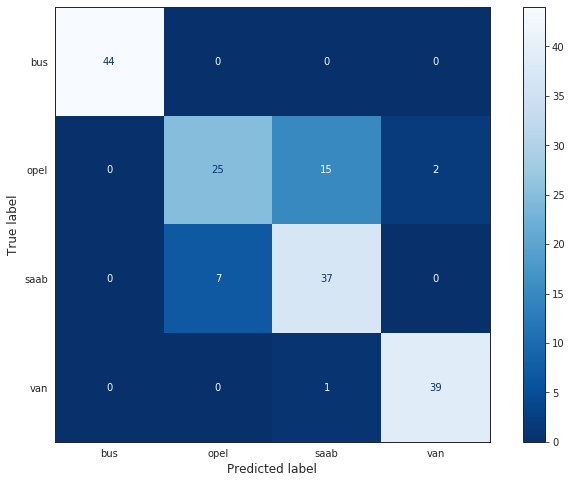

In [13]:
conf = metrics.plot_confusion_matrix(clf, test_X, test_y, cmap=plt.cm.Blues_r)
print(conf)

This is going to be our most important visualization. We can clearly infer the following things from here:
* Perfect classification of the class **bus**
* Near to perfect classification of the class **van**
* Average classification of the class **saab**
* Below average classification of the class **opel**

With this information in hand, we do not really need to dig into the classes **bus** and **van**. However, classes **saab** and **opel** require attention.

I'll be using this information to come up with a better classification accuracy in a separate notebook, but for now let's see what we can conclude from some other visualization processes.

## Convert the classes to one-hot encoding

One-hot encoding is required for the one-vs-rest classifier. The advantage it provides is that every column now represents a class and holds a binary value denoting whether that class is the correct label for any given data point or row. This can be clearly understood when we print the one-hot encoded matrix.

In [14]:
train_y_bin = label_binarize(train_y, ['opel', 'bus', 'saab', 'van']) #class values provided
test_y_bin = label_binarize(test_y, ['opel', 'bus', 'saab', 'van'])

Let's see how it is actually encoded.

In [15]:
print(train_y[0:5].values, '\n')
print(train_y_bin[0:5], '\n')

['van' 'bus' 'opel' 'van' 'van'] 

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]] 



Please ignore the below cell, it is for formatting the below table to align to the left of the cell instead of the center.

In [16]:
%%html
<style>
table {float:left}
</style>

As expected, the class encoding is as follows:

| Class | Index |
| --- | --- |
| opel | 0 |
| bus | 1 |
| saab | 2 |
| van | 3 |

## One-vs-rest classifier

A one-vs-rest classifier, as the name suggests, classifies each class as being the correct class or not.
For eg: Say we have 4 possible classes A, B, C and D, out of which only class A is correct for a particular input. The classifier will convert this into 4 binary classification sub tasks where the label for class A will read 1 while the rest will read 0 for that row.

In [17]:
classifier = OneVsRestClassifier(clf)
#decision_function returns the distance between each sample and the decision boundary for each class
y_score = classifier.fit(train_X, train_y_bin).decision_function(test_X)

Displaying *y_score* can give us an idea of the dimensions and output of *decision_function*.

In [18]:
y_score[0:5]

array([[-2.05051130e+01,  2.93688472e+00, -1.75597649e+01,
        -4.36751754e+00],
       [ 3.90802218e+00, -4.13412371e+01,  7.28644846e+00,
        -1.86267612e+02],
       [-1.37828054e+00, -1.10000554e+02,  9.91186568e+00,
        -9.30205975e+02],
       [ 2.67584129e+00, -4.53628641e+01, -4.55457636e+00,
        -1.95724984e+03],
       [ 3.56880780e+00, -6.68151860e+01,  3.35635402e+00,
        -8.79999965e+02]])

We keep a variable *n_classes* so as to make our modules generalised for any number of classes.

In [19]:
n_classes = 4

## ROC curves

The more the area inside a curve, the better the classification is.
* fpr - false positive rate
* tpr - true positive rate
* roc_auc - area under roc curve

ROC curves are generally helpful when incorrect predictions are class-wise balanced, which is not the case here.

In [20]:
fpr, tpr, roc_auc = multiclass_roc(n_classes, test_y_bin, y_score)

*fpr*, *tpr* and *auc* are dicts storing the corresponding values where each class is an entry.

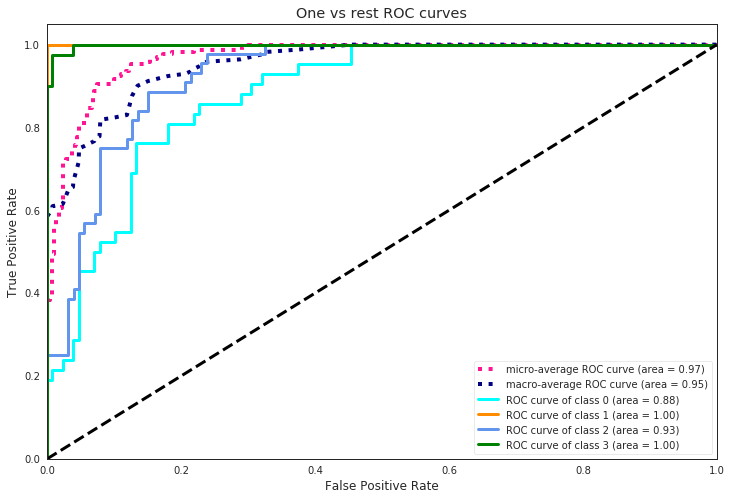

In [21]:
plot_roc(fpr, tpr, roc_auc, n_classes=4)

As we have already mentioned (by analysing the confusion matrix), the curves for **opel** and **saab** depict a scope of improvement even though their AUC scores (area under curve) are pretty good.

In [22]:
print_roc_auc_score(classifier, test_X, test_y_bin)

One-vs-One ROC AUC scores:
0.952103 (macro),
0.951823 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.952103 (macro),
0.951823 (weighted by prevalence)


Overall classification is also satisfactory when we use ROC-AUC score as a metric (which we shouldn't for imbalanced predictions like this).

## Precision recall curve

precision = true positives / (true positives + false positives)
recall = true positives / (true positives + false negatives)

In [23]:
precision, average_precision, recall = multiclass_precision_recall(n_classes, test_y_bin, y_score)

Average precision score, micro-averaged over all classes: 0.92


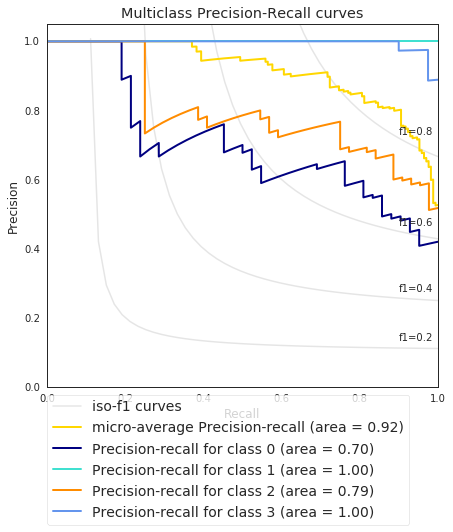

In [24]:
plot_precision_recall(n_classes, precision, average_precision, recall)

In [25]:
# wrong info on imbalance and stuff, need to change

In [57]:
clf = ensemble.GradientBoostingClassifier(max_features='sqrt')
clf.fit(train_X, train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [58]:
clf.score(train_X, train_y)

0.9896449704142012

In [59]:
clf.score(test_X, test_y)

0.7941176470588235

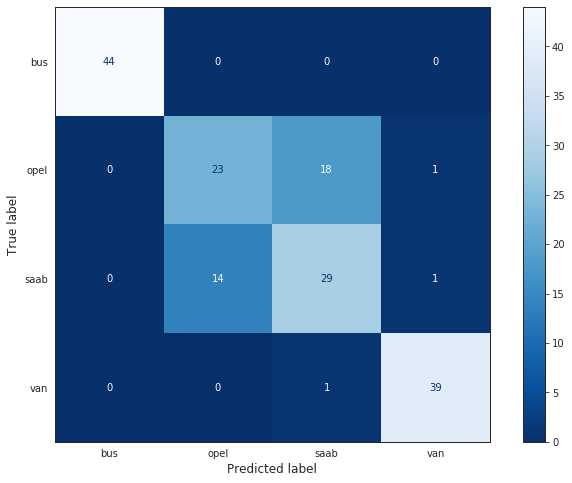

In [60]:
conf = metrics.plot_confusion_matrix(clf, test_X, test_y, cmap=plt.cm.Blues_r)
print(conf)

In [54]:
df_new = df[df.Class != 'bus']

In [55]:
df_new = df_new[df_new.Class != 'van']

In [56]:
df_new

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
9,93,44,98,197,62,11,183,36,22,146,202,505,152,64,4,14,195,204,saab
11,90,34,66,136,55,6,123,54,17,118,148,224,118,65,5,26,196,202,saab
15,96,55,103,201,65,9,204,32,23,166,227,624,246,74,6,2,186,194,opel
18,104,54,100,186,61,10,216,31,24,173,225,686,220,74,5,11,185,195,saab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,94,46,77,169,60,8,158,42,20,148,181,373,181,67,12,2,193,199,saab
840,93,34,66,140,56,7,130,51,18,120,151,251,114,62,5,29,201,207,opel
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,saab
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,saab


In [61]:
X_new = df_new.drop(labels='Class', axis=1)  # Drop the target attribute from the X variable
# We are not normalising the data for this particular notebook.
y_new = df_new.Class  # The target attribute to be predicted

In [62]:
new_train_X, new_test_X, new_train_y, new_test_y = model_selection.train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [84]:
# clf_new = ensemble.GradientBoostingClassifier()
clf_new = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf_new.fit(new_train_X, new_train_y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [85]:
clf_new.score(new_train_X, new_train_y)

0.8600583090379009

In [87]:
clf_new.score(new_test_X, new_test_y)

0.7790697674418605

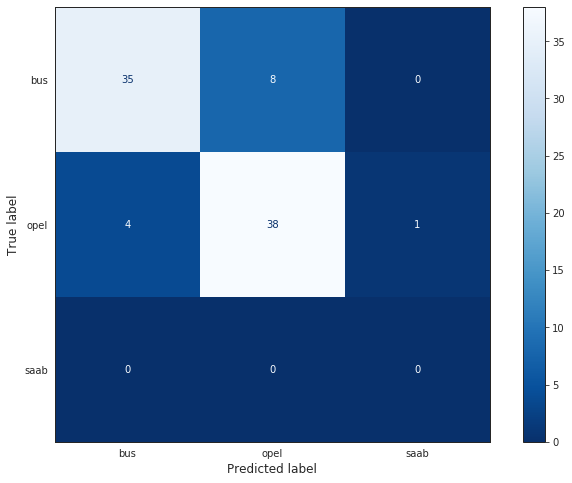

In [89]:
conf = metrics.plot_confusion_matrix(clf, new_test_X, new_test_y, cmap=plt.cm.Blues_r)
print(conf)

In [80]:
new_test_y.value_counts()

saab    43
opel    43
Name: Class, dtype: int64